<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving metrics.py to metrics.py
Saving utils.py to utils.py


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Dataset/COMP5329S1A2Dataset/data/550.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5500.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5501.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5502.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5503.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5504.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5505.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5506.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5507.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5508.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5509.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/551.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5510.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5511.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5512.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5513.jpg  
  inflating: Dataset/COMP5329

In [25]:
# Model arcitechture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64,3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout3d(1-0.9)
        self.dropout2 = nn.Dropout3d(1-0.75)
        self.dropout3 = nn.Dropout(1-0.5)
        self.fc1 = nn.Linear(14400, 1000)
        self.fc2 = nn.Linear(1000, 19)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.dropout2(x)
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.dropout2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logits = self.fc2(x)
        return logits

We are using GPU.
Model initialized.


  0%|          | 0/2 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.760325



 50%|█████     | 1/2 [01:14<01:14, 74.44s/it]


Test set results: Average loss: 0.2660, F1 Score: 0.54


Train Epoch: 1 [0/23996 (0%)]	Loss: 0.396422



100%|██████████| 2/2 [02:27<00:00, 73.95s/it]



Test set results: Average loss: 0.2248, F1 Score: 0.57



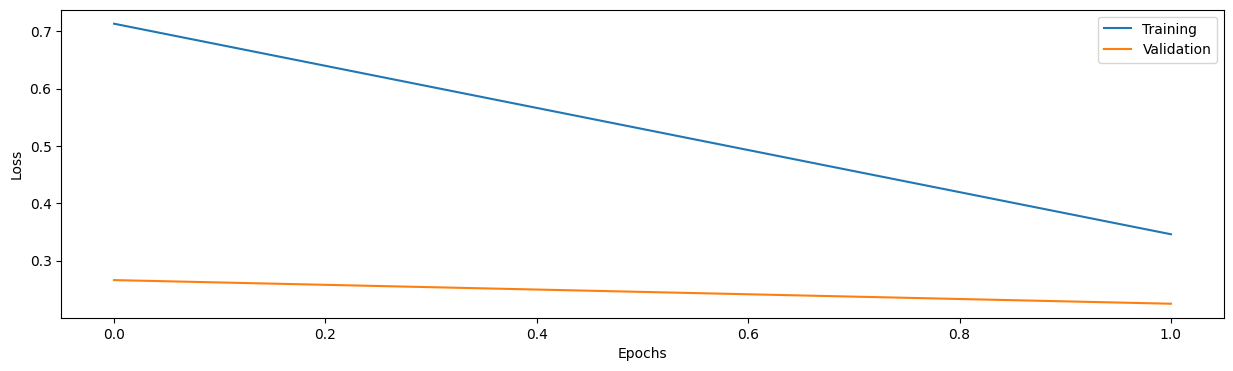

100%|██████████| 6000/6000 [00:20<00:00, 294.74it/s]



Test set results: Average loss: 0.2249, F1 Score: 0.57

6000
{'F1_score': 0.5729457417114847, 'accuracy': 0.9449736842105263, 'precision': 0.7702727439136006, 'recall': 0.45610231953175806}


In [26]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split

from Dataload import pil_process_image_color, encode, CustomImageDataset
from utils import test, train_network, pos_weight
from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 512
lr = 0.001
# To remove class 12
#weights = torch.ones(19)
#weights[11] = 0

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# To get overview
#print(df_test.describe)

# Defining transforms
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # Trying to resize to (INPUT_HEIGHT,INPUT_WIDTH)

# TODO: we can add data augmentation here
# See for example https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# or here: https://docs.pytorch.org/vision/main/transforms.html
trainTransforms = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.ToTensor()])
testTransforms = transforms.Compose([resize,transforms.ToTensor()])

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data)

# Setup model
model = CNN().to(device)
weights = pos_weight(df_train,barplot=False).to(device)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print('Model initialized.')

# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")
# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset)

# Training
log_interval = 100 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=2)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Testing on validation set and get
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, target_available=True) # output predictions as tensors
all_preds = np.asarray([np.asarray(tensor.cpu()) for tensor in all_preds])
all_targets = np.asarray([np.asarray(tensor.cpu()) for tensor in all_targets])
metrics = compute_metrics(all_preds,all_targets)
print(metrics)

In [ ]:
# Compute predictions for true test set
#val_pred = test(model, device, test_dataloader,loss,target_available=False)
# save model
torch.save(model, "content/model_full.pt")

100%|██████████| 10000/10000 [00:28<00:00, 352.94it/s]


Predictions computed for test set.


In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

def get_class(array):
  return np.where(array > 0.5)[1] +1

def unencode(y_pred):
  labels = []
  for i in tqdm(range(len(y_pred))):
    temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels #pd.DataFrame(labels)

#cpu_preds = torch.tensor(val_pred, device =  'cpu')
pred_labels= unencode(val_pred)
#pred_labels = unencode(cpu_preds
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print()
print(pred_df.describe)
pred_df.to_csv("/content/submission.csv",index=False)

100%|██████████| 10000/10000 [00:00<00:00, 25031.74it/s]


1 8

<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg    1 8
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg    1 3
...         ...    ...
9995  39995.jpg       
9996  39996.jpg  1 3 4
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>


In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "first submission"

100% 120k/120k [00:00<00:00, 710kB/s]
Successfully submitted to Multi-label Classification Competition 2025